## Tweet Emotion Recognition: Natural Language Processing with TensorFlow
### Team no: 8
### Members: A. Santosh Jayanth, P. Sriya Chowdary, B. Chakradhar Sai Aditya, D. Leela Venkateswara Reddy

## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 212 kB 67.6 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
data = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
data

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = data['train']
val = data['validation']
test = data['test']
train[0]

{'label': 'sadness', 'text': 'i didnt feel humiliated'}

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

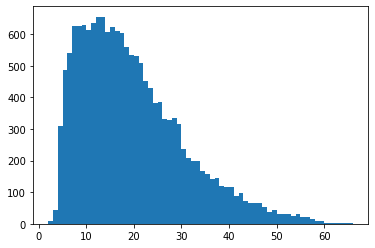

In [12]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [13]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [15]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [16]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [17]:
classes = set(labels)
print(classes)

{'joy', 'love', 'anger', 'surprise', 'sadness', 'fear'}


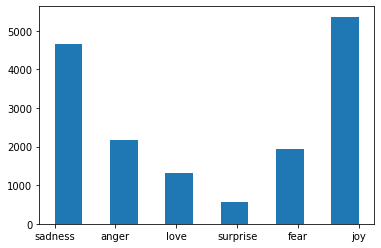

In [18]:
plt.hist(labels, bins=11)
plt.show()

In [19]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [20]:
class_to_index

{'anger': 2, 'fear': 5, 'joy': 0, 'love': 1, 'sadness': 4, 'surprise': 3}

In [21]:
index_to_class

{0: 'joy', 1: 'love', 2: 'anger', 3: 'surprise', 4: 'sadness', 5: 'fear'}

In [22]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [23]:
train_labels = names_to_ids(labels)
print(train_labels[0])

4


## Creating the Model

1. Creating the model
2. Compiling the model

In [54]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(100000, 26, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(500, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(250, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [55]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 26)            2600000   
                                                                 
 bidirectional_10 (Bidirecti  (None, 50, 1000)         2108000   
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 50, 500)          2502000   
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 200)              480800    
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 6)                 1206      
                                                      

## Training the Model

1. Preparing a validation set
2. Training the model

In [56]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [57]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [58]:
h = model.fit(padded_train_seq, train_labels,
              validation_data = (val_seq, val_labels),
              epochs=20,
              callbacks=[
                         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
              ])


Epoch 1/20
500/500 [==============================] - 27s 41ms/step - loss: 0.9863 - accuracy: 0.6212 - val_loss: 0.3843 - val_accuracy: 0.8690
Epoch 2/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2445 - accuracy: 0.9134 - val_loss: 0.2484 - val_accuracy: 0.9075
Epoch 3/20
500/500 [==============================] - 18s 36ms/step - loss: 0.1596 - accuracy: 0.9364 - val_loss: 0.2123 - val_accuracy: 0.9175
Epoch 4/20
500/500 [==============================] - 18s 36ms/step - loss: 0.1253 - accuracy: 0.9452 - val_loss: 0.2009 - val_accuracy: 0.9255
Epoch 5/20
500/500 [==============================] - 18s 37ms/step - loss: 0.0946 - accuracy: 0.9586 - val_loss: 0.1774 - val_accuracy: 0.9320
Epoch 6/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0868 - accuracy: 0.9620 - val_loss: 0.2460 - val_accuracy: 0.9130
Epoch 7/20
500/500 [==============================] - 18s 36ms/step - loss: 0.0721 - accuracy: 0.9672 - val_loss: 0.1772 - val_accuracy:

## Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

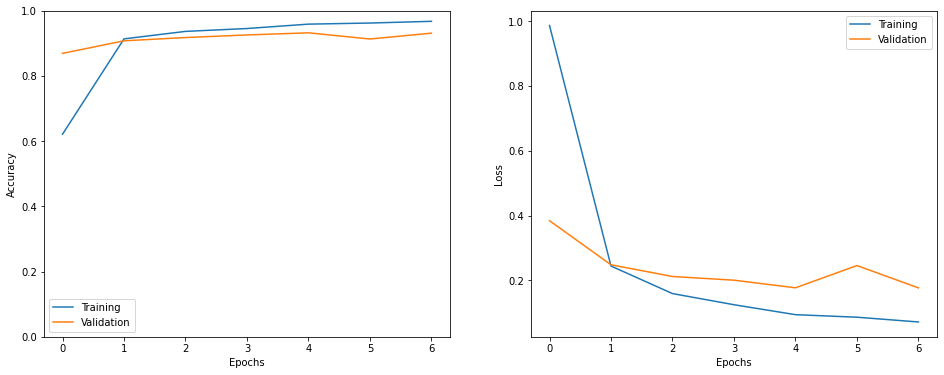

In [59]:
show_history(h)

In [60]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [61]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 16ms/step - loss: 0.1807 - accuracy: 0.9260


In [62]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i feel happy about the outcome of this long election and im glad its over
Emotion: joy
Predicted Emotion: joy


In [63]:
preds = model.predict(test_seq)
classes_pred = np.argmax(preds,axis=1)

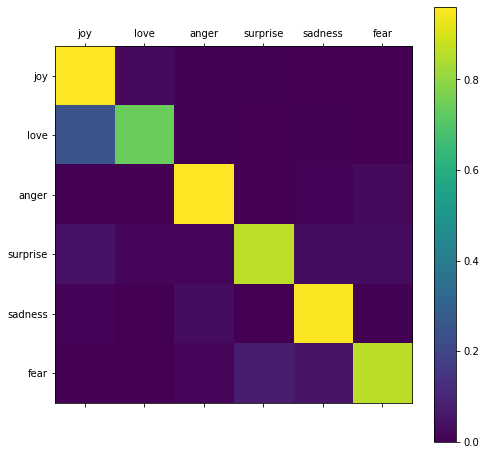

In [64]:
show_confusion_matrix(test_labels, classes_pred, list(classes))

In [70]:
sentence = "Oops! he lost the match."
sent = get_sequences(tokenizer,[sentence])
sent
final_sent = model.predict(sent)
maxa = np.max(final_sent[0])
for i,j in enumerate(final_sent[0]):
  if j==maxa:
    print(index_to_class[i])

sadness
